# Run this before anything starts

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import cv2 as cv
from PIL import Image
import pickle
import random
from numpy import savetxt
import tensorflow as tf

from utility_function import img_resize, model_namer, model_namer_description, save_ml_model, load_ml_model, load_training_data

# ConvNet shape calculator

In [74]:
def ConvSize(input_shape = [895, 16, 16], stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0):
    out_shape = []
    for i in range(len(input_shape)):
        out = (input_shape[i] - kernal_shape[i] + 2 * zero_pad)/stride[i] + 1
        out_shape.append(out)
    return out_shape

def Pooling(input_shape = [895, 16, 16], stride = [2, 2, 2], pool_shape = [2, 2, 2]):
    out_shape = []
    for i in range(len(input_shape)):
        out = np.floor((input_shape[i] - pool_shape[i]) / stride[i]) + 1
        out_shape.append(out)
    return out_shape
    

[220.0, 0.0, 0.0]

In [80]:
# Maximum 2 conv layer followed by 2 pool layer
lay1 = ConvSize(input_shape = [895, 16, 16], stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
pool1 = Pooling(input_shape = lay1, stride = [2, 2, 2], pool_shape = [2, 2, 2])
lay2 = ConvSize(input_shape = pool1, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
pool2 = Pooling(input_shape = lay2, stride = [2, 2, 2], pool_shape = [2, 2, 2])
lay3 = ConvSize(input_shape = pool2, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay3

[220.0, 0.0, 0.0]

In [81]:
# Maximum 7 conv layer followed by 1 pool layer
lay1 = ConvSize(input_shape = [895, 16, 16], stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay2 = ConvSize(input_shape = lay1, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay3 = ConvSize(input_shape = lay2, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay4 = ConvSize(input_shape = lay3, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay5 = ConvSize(input_shape = lay4, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay6 = ConvSize(input_shape = lay5, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
lay7 = ConvSize(input_shape = lay6, stride = [1, 1, 1], kernal_shape = [3, 3, 3], zero_pad = 0)
pool1 = Pooling(input_shape = lay7, stride = [2, 2, 2], pool_shape = [2, 2, 2])
pool1

[440.0, 1.0, 1.0]

# (Optional) Load  sample FMC data from .mat file

In [5]:
mat = scipy.io.loadmat('timeTraces.mat')
fmc = mat['timeTraces']

print(list(fmc.shape))
print(type(fmc))

[4472, 16, 16]
<class 'numpy.ndarray'>


(895, 256)


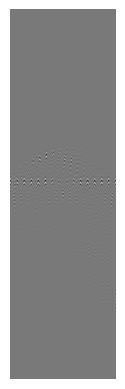

In [7]:
fmc = fmc.reshape(4472, 16 * 16)
fmc = fmc[0::5]/(10**-14) * 255
print(fmc.shape)


plt.imshow(fmc, cmap='gray')
plt.axis('off')
plt.savefig('fmc_image_plt.png')

# Create training data (OUTDATED, check create_training_data.py)

VERY VERY USEFUL VIDEO TUTORIAL!!!\
https://www.youtube.com/watch?v=j-3vuBynnOE

In [38]:
def read_gray_image(dirName, imageName, plotting = False):
    
    image = cv.imread(f'{dirName}/{imageName}', cv.IMREAD_GRAYSCALE)
    print(f'The shape of the GREYSCALE image is {image.shape}')
    if plotting == True:
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.show()
    return image

# read image test
index = 1
dirName_pic = '/Users/chenkangan/PycharmProjects/ME4_FYP_py/py_output_fig'
imgName = f'defect_{index}_yshift_60.png'
image = read_gray_image(dirName_pic, imgName, plotting = False)

In [12]:
def create_training_data(subsample = True):
    training_data = []
    dirName_fmc = '/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/FMC_variable'
    dirName_pic = '/Users/chenkangan/PycharmProjects/ME4_FYP_py/py_output_fig'
    
    for index in range(1,2001):
        filename = f'fmc_{index}.mat'
        imgName = f'defect_{index}_yshift_60.png'
        
        mat = scipy.io.loadmat(f'{dirName_fmc}/{filename}')
        fmc = mat['timeTraces']
        
        if subsample == True:
            fmc = fmc[0::5]
        else:
            pass
        
        image = read_gray_image(dirName_pic, imgName, plotting = False)
        # I need to append ([fmc, label])
        training_data.append([fmc, image, index])
        
    pickle_out = open("training_data_subsampled.pickle","wb")
    pickle.dump(training_data, pickle_out)
    pickle_out.close()
        
    return training_data
        
# subsample every 5th data
# training_data = create_training_data(subsample = True)

# Store training data in a pickle

https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/

In [57]:
import pickle

pickle_out = open("training_data.pickle","wb")
pickle.dump(training_data, pickle_out)
pickle_out.close()

# x contains training data and y contains the label

# pickle_out = open("x.pickle","wb")
# pickle.dump(x, pickle_out)
# pickle_out.close()

# pickle_out = open("y.pickle","wb")
# pickle.dump(y, pickle_out)
# pickle_out.close()

# Load training data from a pickle and check the result

### 1. Load training_data_subsampled.pickle

In [5]:
pickle_in = open("training_data_subsampled.pickle","rb")
train_data = np.array(pickle.load(pickle_in), dtype=object)
print(f'The shape of entire training dataset: {train_data.shape}')
print(f'The shape of a dataset: {train_data[1].shape}')
print(f'The shape of a matrix: {train_data[1][0].shape}')
print(f'The shape of an image: {train_data[1][1].shape}')
print(f'The type of an index: {type(train_data[1][2])}')

The shape of entire training dataset: (2000, 3)
The shape of a dataset: (3,)
The shape of a matrix: (895, 16, 16)
The shape of an image: (180, 240)
The type of an index: <class 'int'>


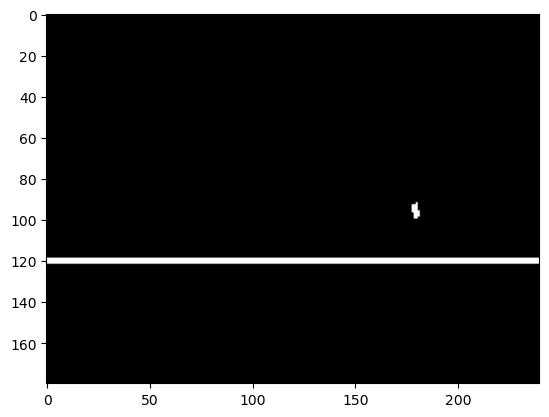

In [53]:
plt.imshow(train_data[100][1], cmap='gray')

Apply scaler on fmc data:
https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix

Random number is 624!
The lucky index is 625!
The random number != index because the 0-index issue that python has.


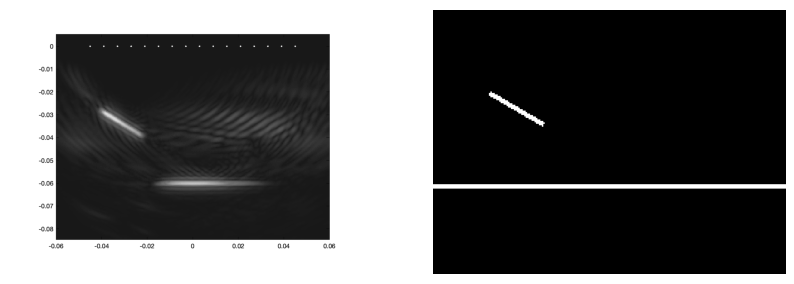

The random column plotted is 10


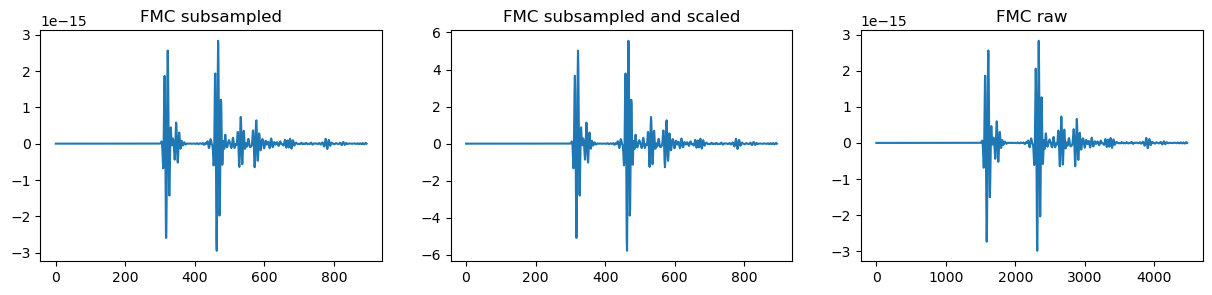

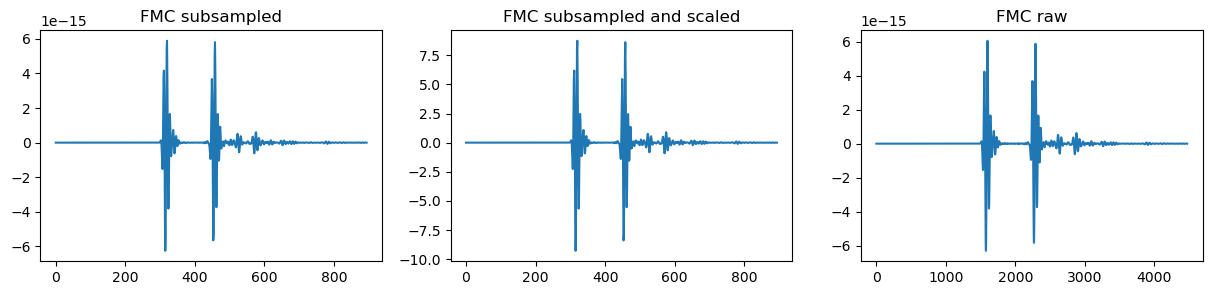

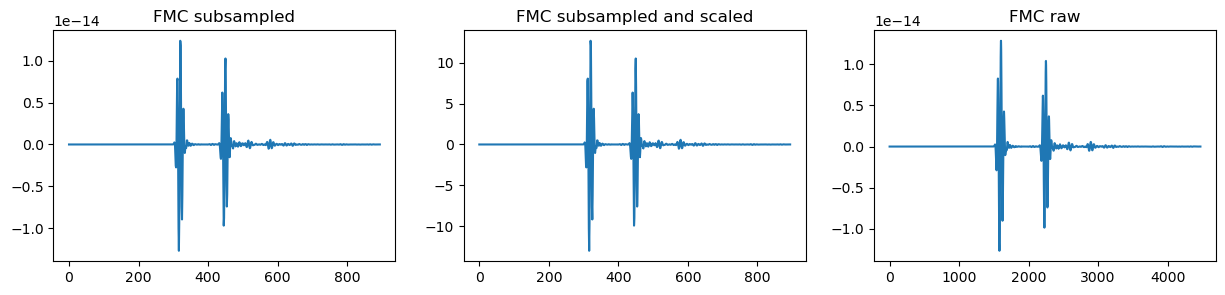

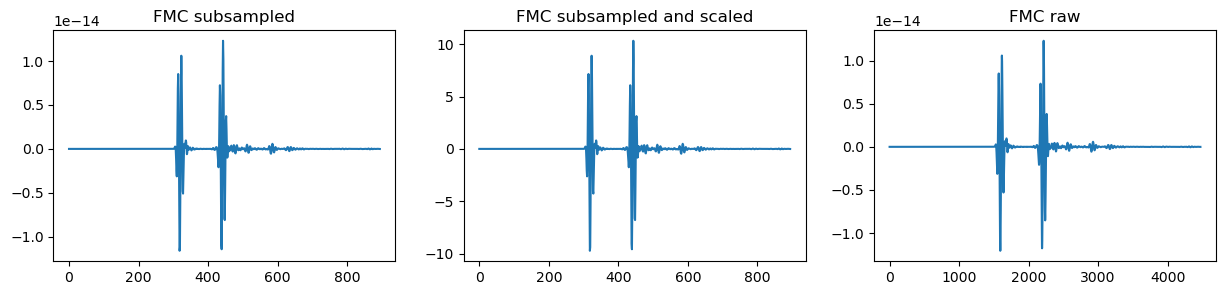

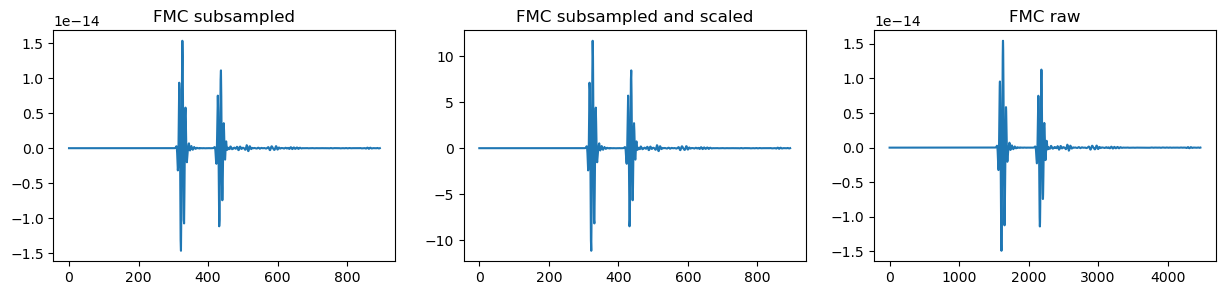

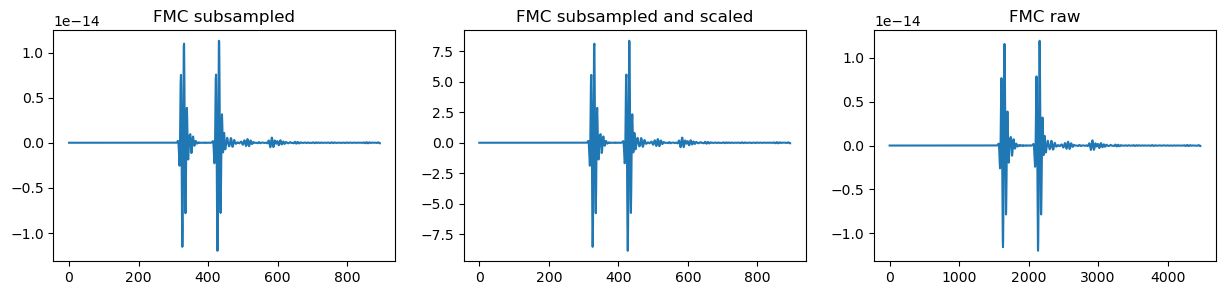

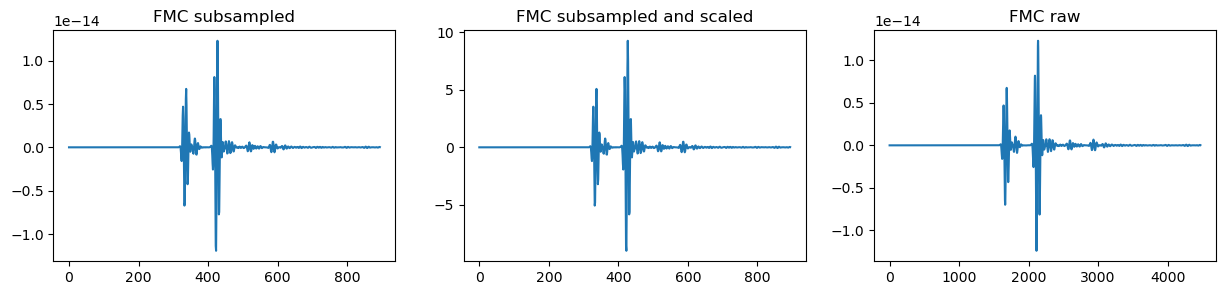

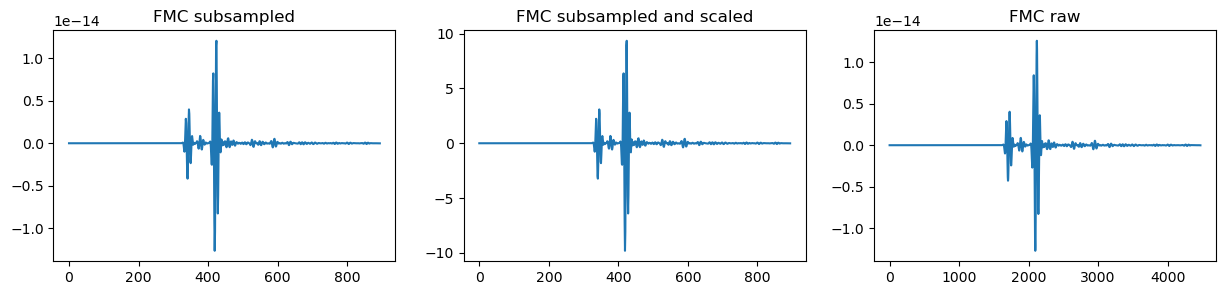

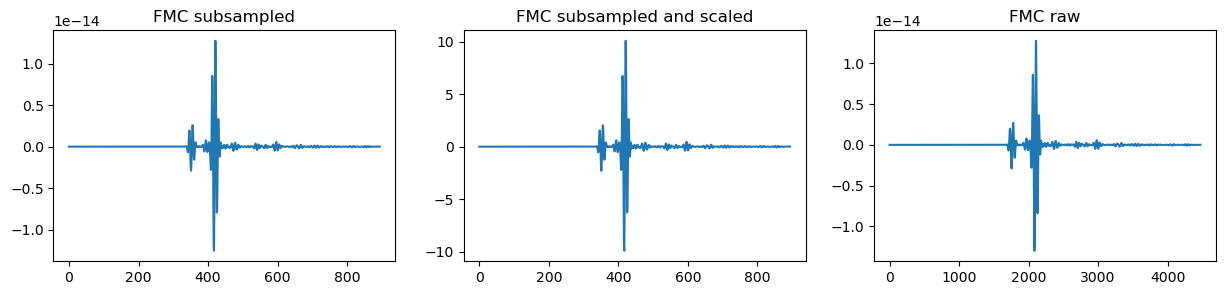

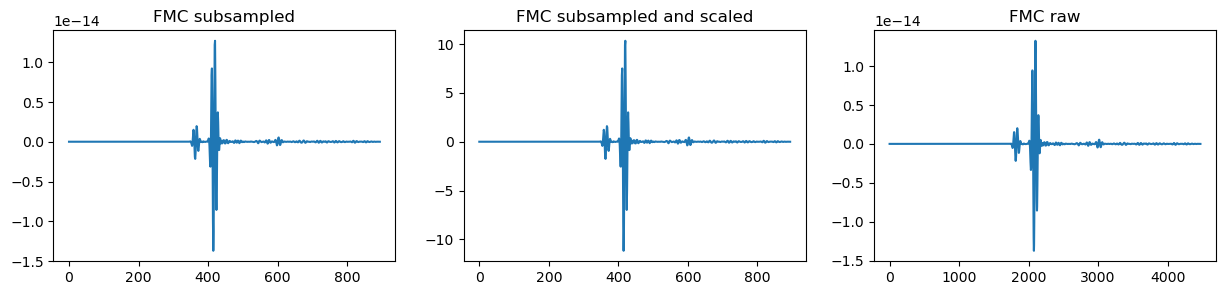

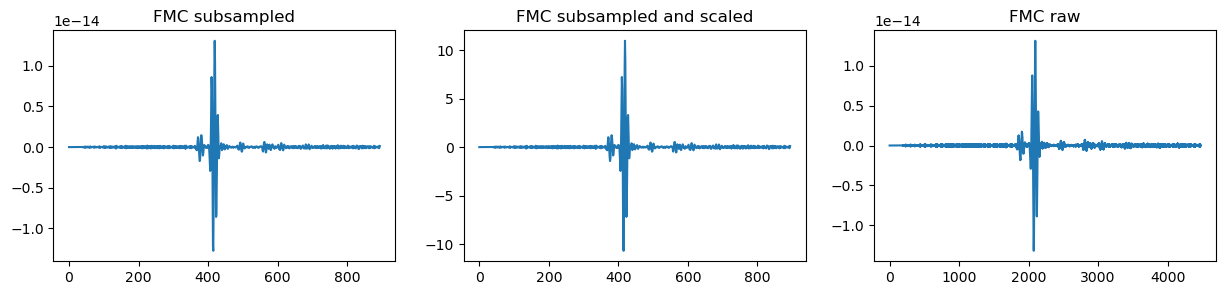

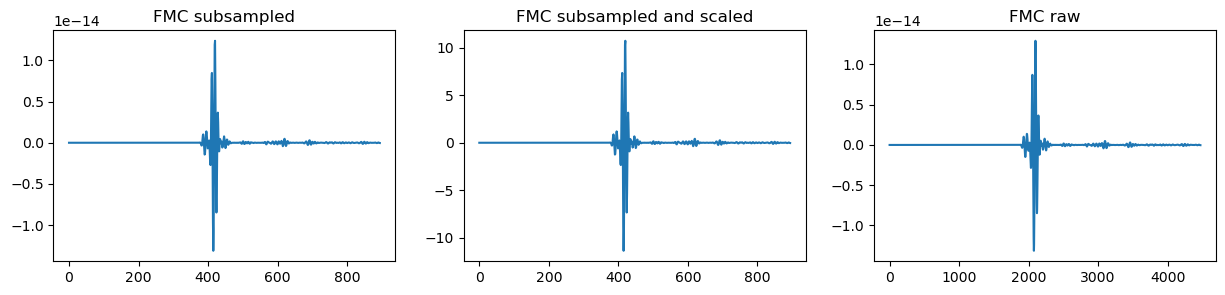

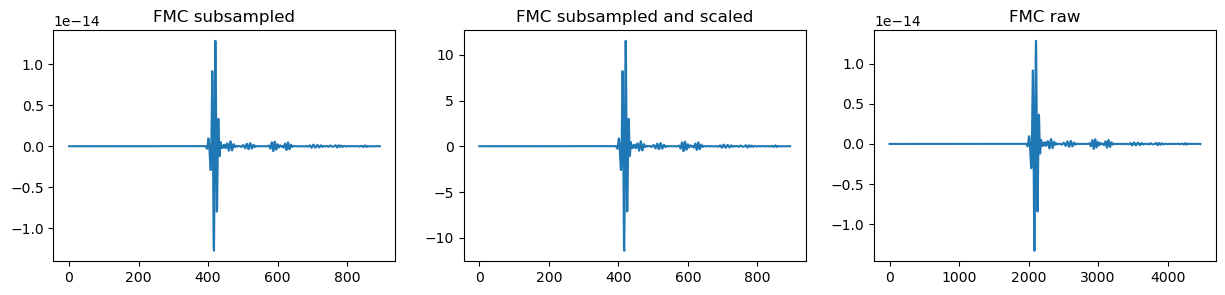

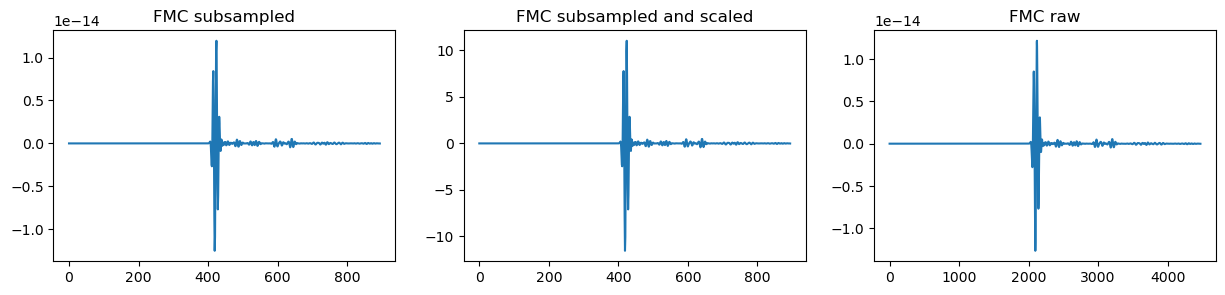

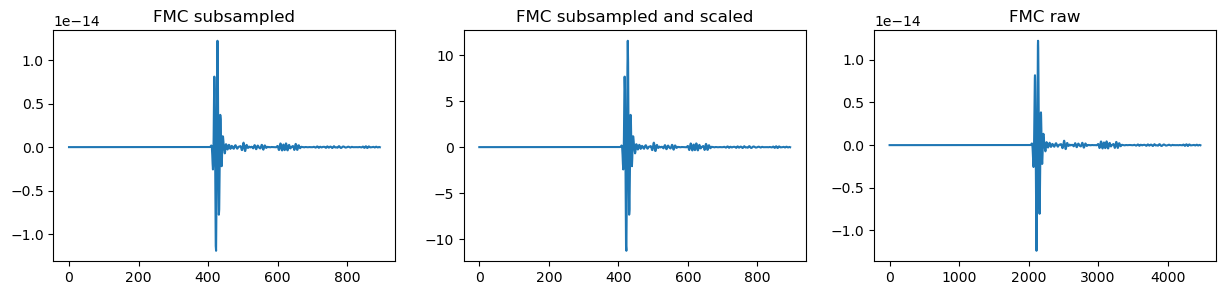

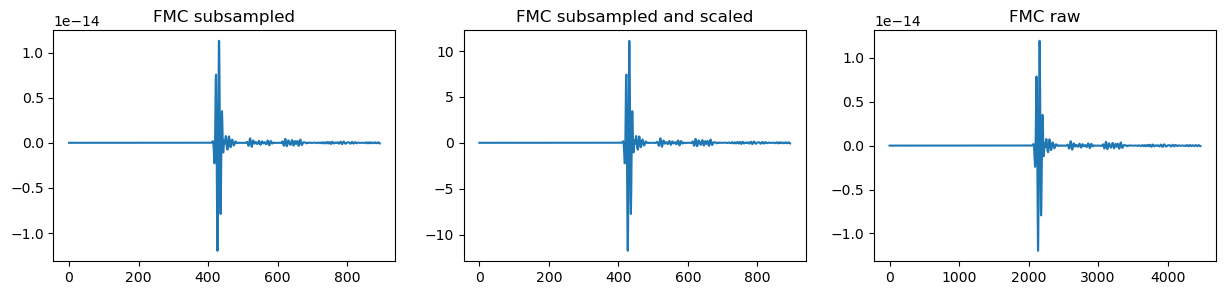

In [19]:
# test whether the data a stored properly

from sklearn.preprocessing import MinMaxScaler, StandardScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()

rand_num = random.randint(1,2001)
print(f'Random number is {rand_num}!')

dirName_das_fmc = "/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/DAS_Figure_FMC"
dirName_fmc = "/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/FMC_variable"

index = train_data[rand_num][2]
print(f'The lucky index is {index}!')
print('The random number != index because the 0-index issue that python has.')

f = plt.figure(figsize=(10,4))

# Read image in greyscale 
image_das_fmc = cv.imread(f'{dirName_das_fmc}/Figure_{index}_fmc.png',cv.IMREAD_GRAYSCALE)  # convert to array

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(image_das_fmc, cmap='gray')
ax.axis('off')
ax2.imshow(train_data[rand_num][1], cmap='gray')
ax2.axis('off')
plt.show()

fmc_select = train_data[rand_num][0]
# print(fmc_select.shape[-1])

# !!! Scale function !!!! NEED TO DOUBLE CHECK !!!!! 
fmc_select_scale = scaler.fit_transform(fmc_select.reshape(-1, fmc_select.shape[-1])).reshape(fmc_select.shape)

filename = f'fmc_{index}.mat'
mat = scipy.io.loadmat(f'{dirName_fmc}/{filename}')
# fmc_raw is not subsampled
fmc_raw = mat['timeTraces']

# plot a random column
rand_col = random.randint(0,15)
print(f'The random column plotted is {rand_col}')

for i in range(0,16):    
    f = plt.figure(figsize=(15,3))
    ax = f.add_subplot(131)
    ax2 = f.add_subplot(132)
    ax3 = f.add_subplot(133)
    ax.set_title('FMC subsampled')
    ax.plot(fmc_select[:,rand_col,i])
    ax2.set_title('FMC subsampled and scaled')
    ax2.plot(fmc_select_scale[:,rand_col,i])
    ax3.set_title('FMC raw')
    ax3.plot(fmc_raw[:,rand_col,i])
    plt.show()


### 2. Load training_data_subsampled_x and y.pickle (Update 22/2/23)

In [2]:
pickle_in = open("data_subsampled_no_backwall_crop_3500_X.pickle","rb")
X = np.array(pickle.load(pickle_in), dtype=object)
print(f'The shape of entire training dataset: {X.shape}')
print(f'The shape of a dataset: {X[1].shape}')

The shape of entire training dataset: (3500, 895, 16, 16, 1)
The shape of a dataset: (895, 16, 16, 1)


In [3]:
pickle_in = open("data_subsampled_no_backwall_crop_3500_y.pickle","rb")
y = np.array(pickle.load(pickle_in), dtype=object)
print(f'The shape of entire training dataset: {y.shape}')
print(f'The shape of a dataset: {y[1].shape}')

The shape of entire training dataset: (3500, 120, 240)
The shape of a dataset: (120, 240)


Random number is 2593!
Image size after is (60, 120) after resizing 50%


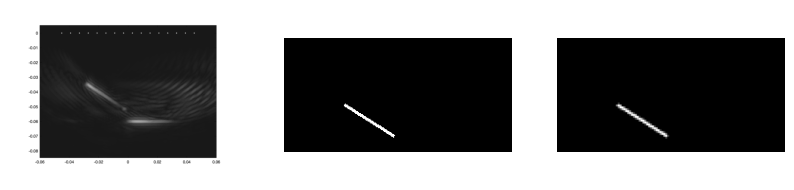

The random column plotted is 7


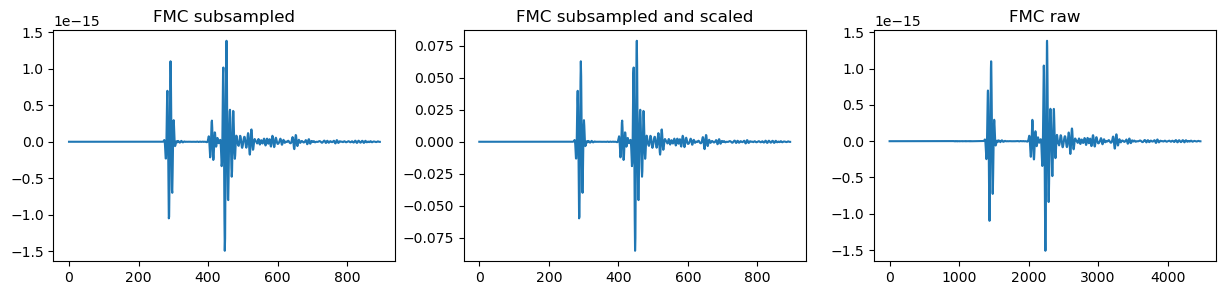

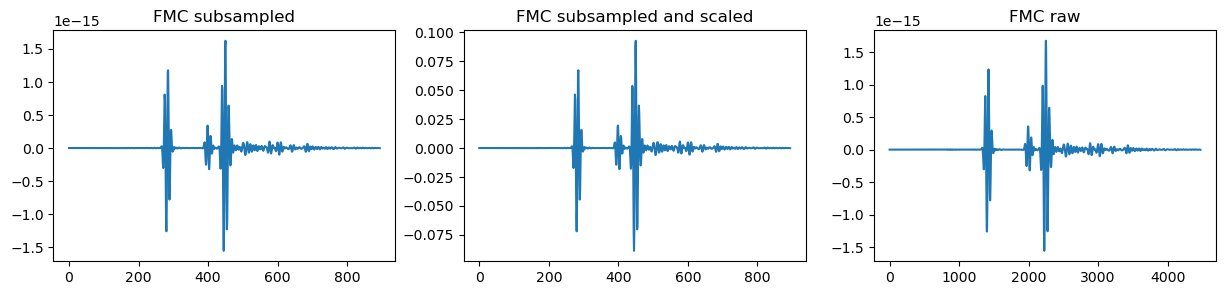

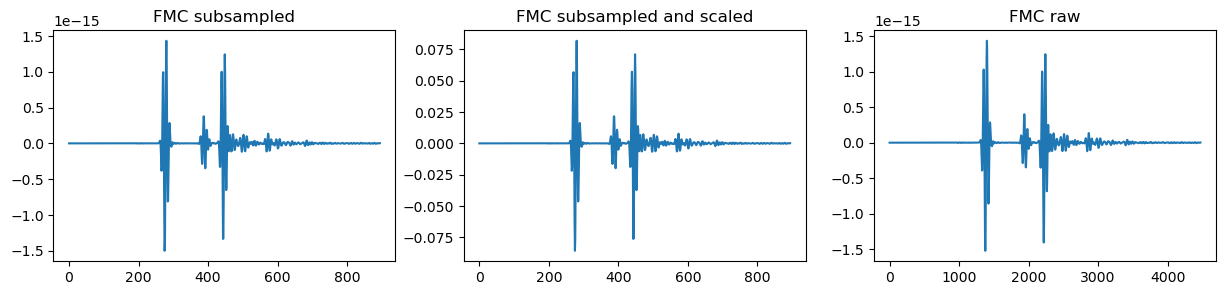

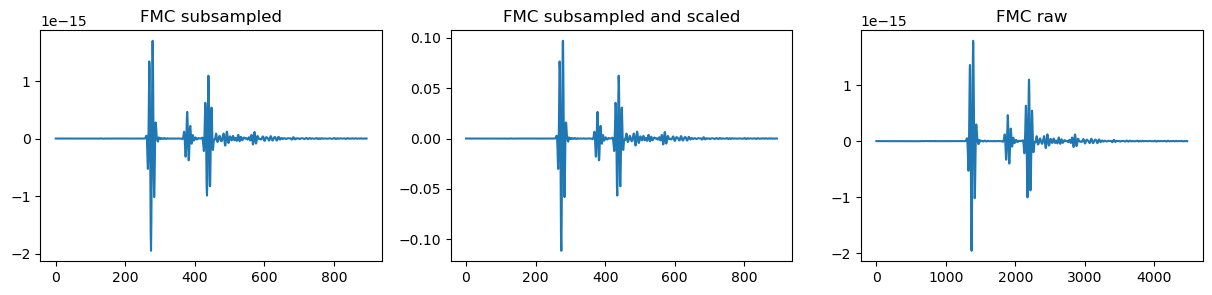

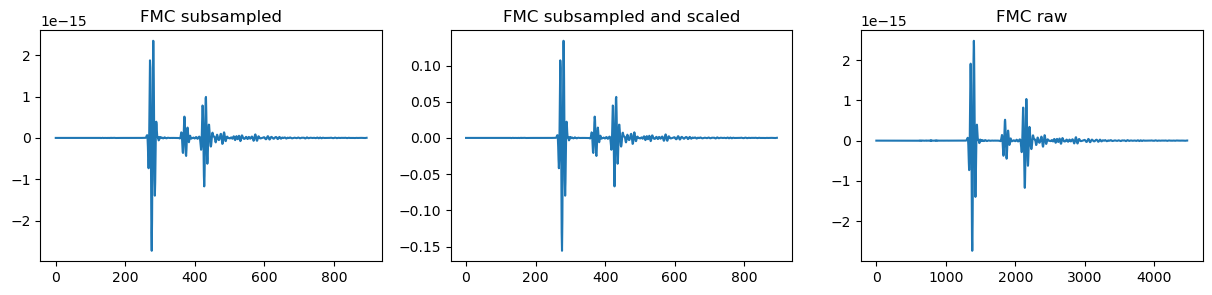

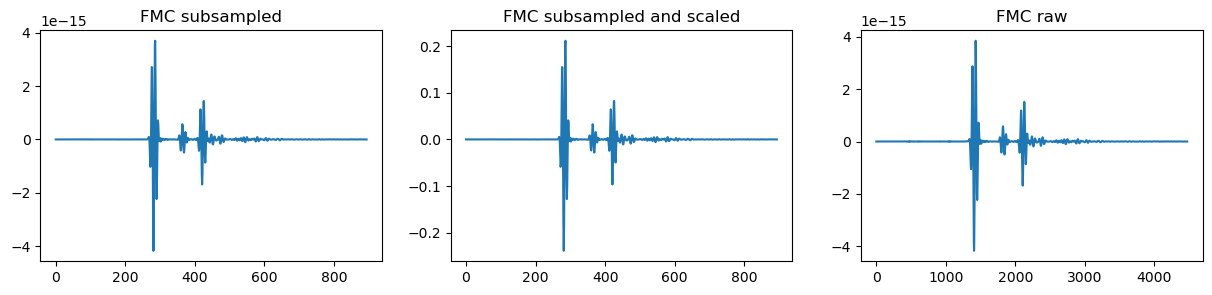

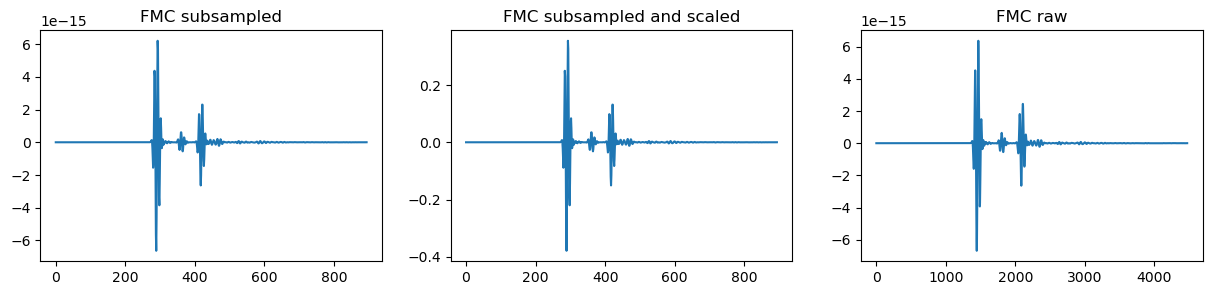

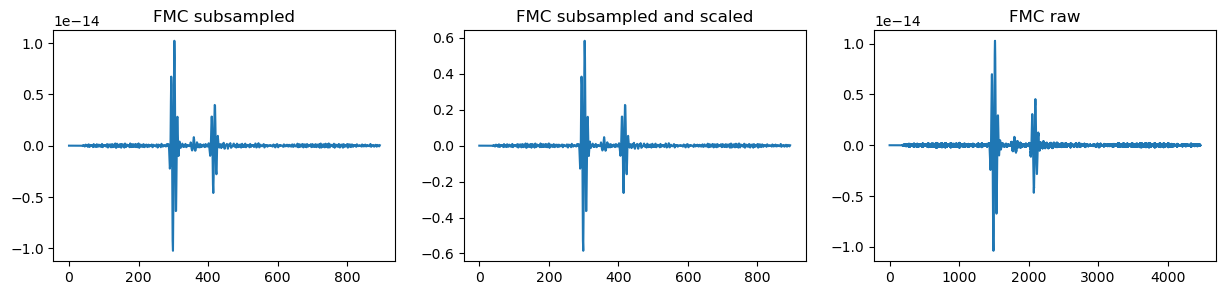

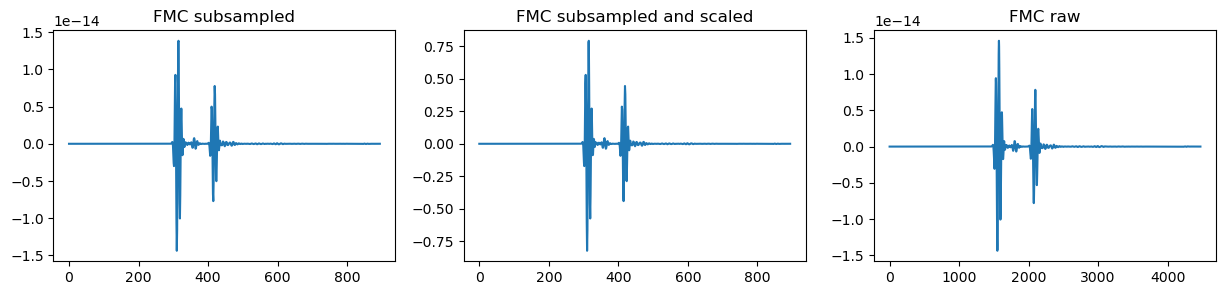

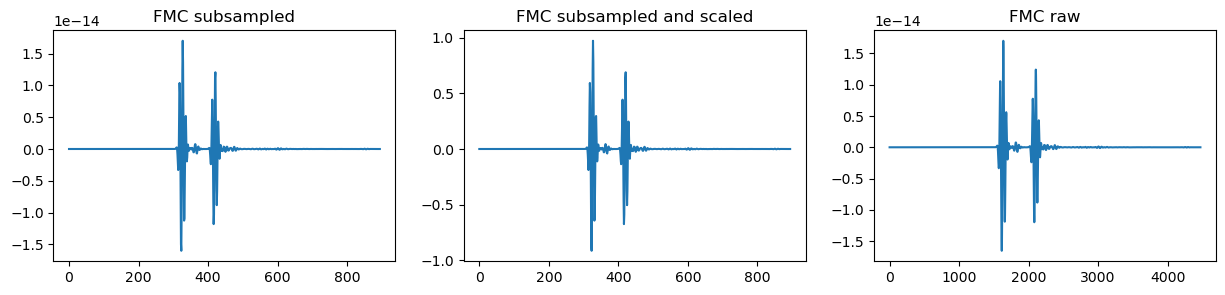

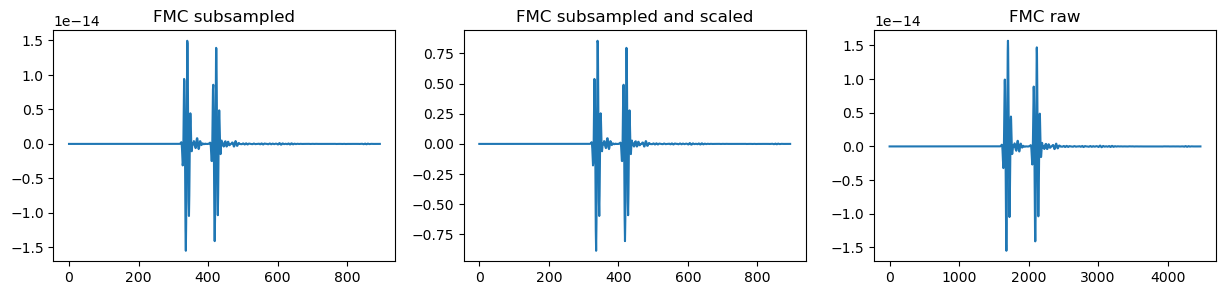

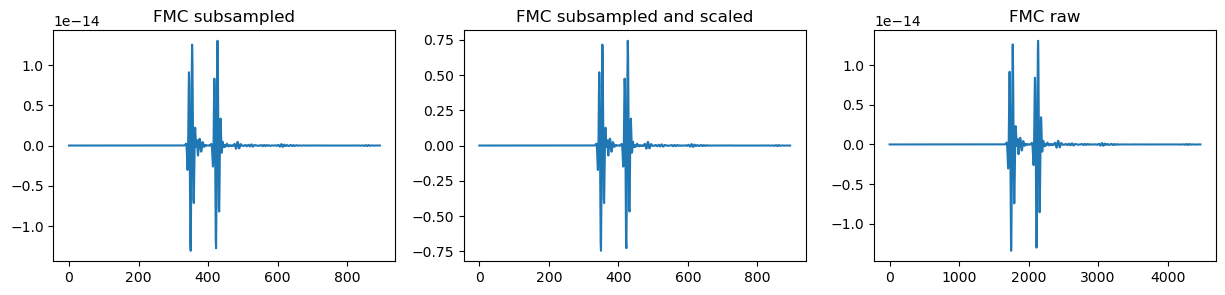

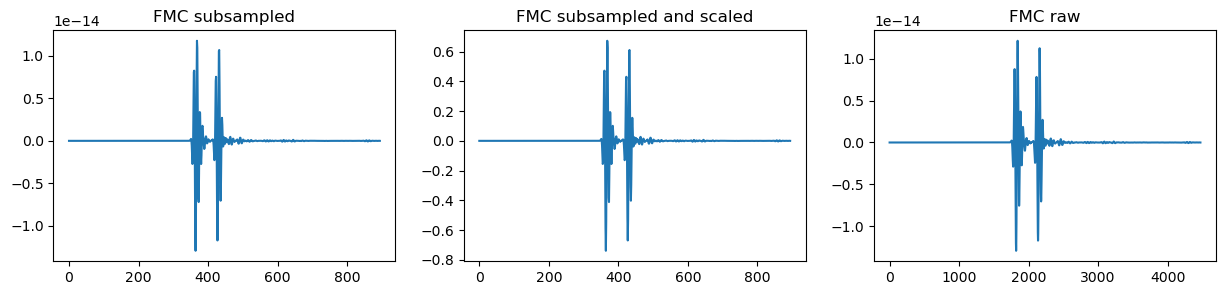

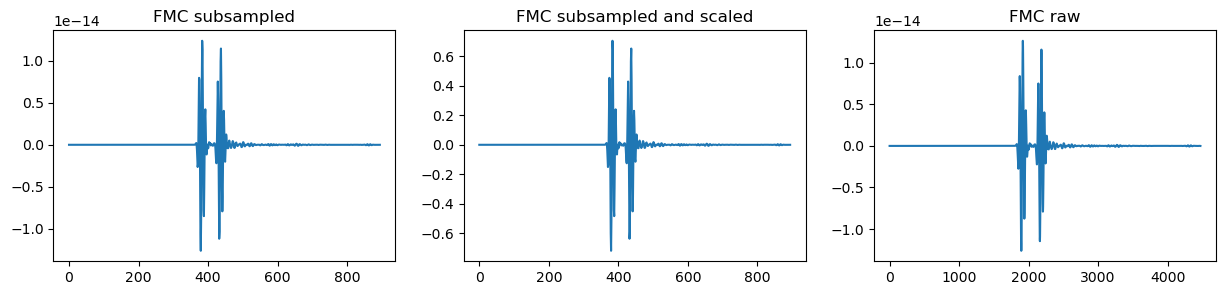

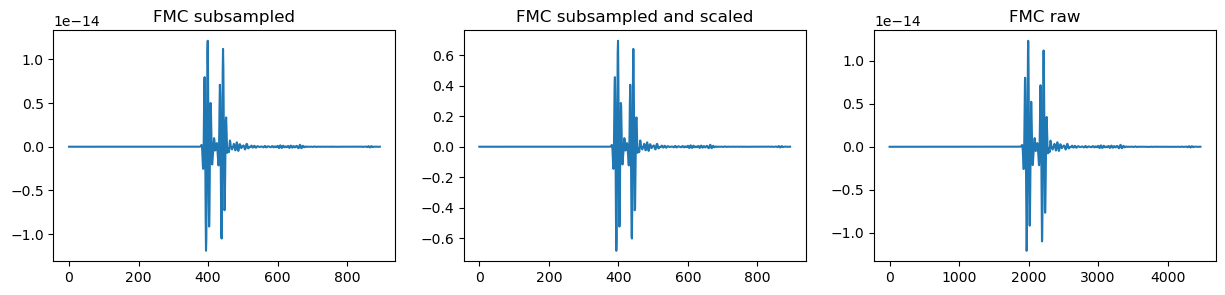

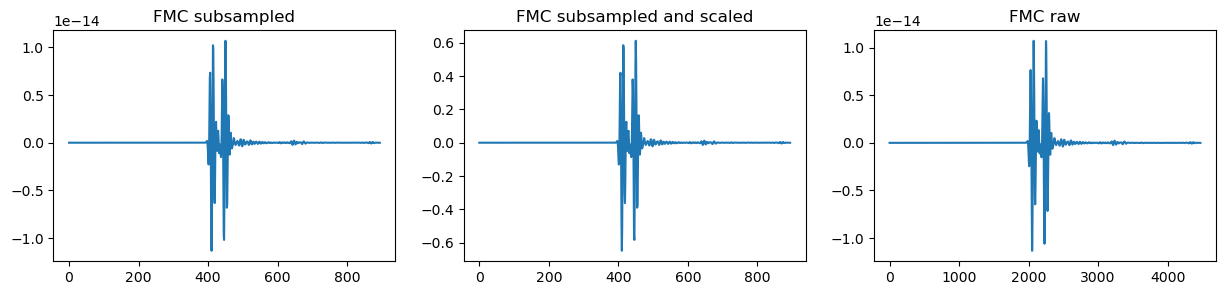

In [6]:
# test whether the data a stored properly

rand_num = random.randint(1,3501)
print(f'Random number is {rand_num}!')

# Directory of the files
dirName_das_fmc = "/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/DAS_Figure_FMC"
dirName_fmc = "/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/FMC_variable"

index = rand_num + 1
f = plt.figure(figsize=(10,4))

# Read image in greyscale 
image_das_fmc = cv.imread(f'{dirName_das_fmc}/Figure_{index}_fmc.png',cv.IMREAD_GRAYSCALE)  # convert to array
yplot = y[rand_num].astype('float')

scale_percent = 50 # percent of original size
width = int(yplot.shape[1] * scale_percent / 100)
height = int(yplot.shape[0] * scale_percent / 100)
dim = (width, height)

yplot_resize = cv.resize(yplot, dim, interpolation = cv.INTER_AREA)
print(f'Image size after is {yplot_resize.shape} after resizing {scale_percent}%')

# Plot the images (y)
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
ax.imshow(image_das_fmc, cmap='gray')
ax.axis('off')
ax2.imshow(yplot, cmap='gray')
ax2.axis('off')
ax3.imshow(yplot_resize, cmap='gray')
ax3.axis('off')
plt.show()

fmc_select = X[rand_num]
# print(fmc_select.shape[-1])

# Scale function 
fmc_select_scale = fmc_select / 1.75e-14

filename = f'fmc_{index}.mat'
mat = scipy.io.loadmat(f'{dirName_fmc}/{filename}')
# fmc_raw is not subsampled
fmc_raw = mat['timeTraces']

# plot a random column of fmc
rand_col = random.randint(0,15)
print(f'The random column plotted is {rand_col}')

for i in range(0,16):    
    f = plt.figure(figsize=(15,3))
    ax = f.add_subplot(131)
    ax2 = f.add_subplot(132)
    ax3 = f.add_subplot(133)
    ax.set_title('FMC subsampled')
    ax.plot(fmc_select[:,rand_col,i])
    ax2.set_title('FMC subsampled and scaled')
    ax2.plot(fmc_select_scale[:,rand_col,i])
    ax3.set_title('FMC raw')
    ax3.plot(fmc_raw[:,rand_col,i])
    plt.show()


# Create tensorflow data pipeline to apply mirror strategy

In [14]:
x_dimension = 3
img_resize_factor = 50
shrinkx = True

X, y = load_training_data(num_sample=100, 
                          x_dimension=x_dimension, 
                          img_resize_factor=img_resize_factor,
                          shrinkx = shrinkx)

# change the type (in order to build tf pipeline)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

The original shape of X is (100, 895, 16, 16, 1)
The shape of X after shrinking is (100, 865, 16, 16, 1)
The shape of y is (100, 7200)


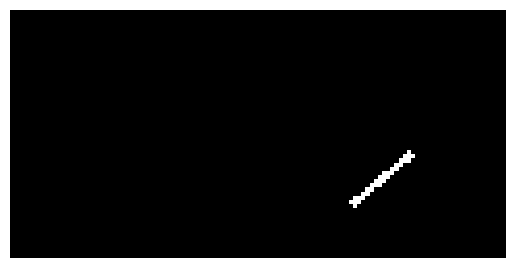

In [26]:
y = y.reshape(-1, 60, 120)
y.shape
plt.imshow(y[1], cmap='gray')
plt.axis('off')
plt.show()

In [27]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [28]:
# Build tensorflow data pipeline for better efficiency
# ref: https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/43_distributed_training/dgx_benchamrking_tf_mirrored_stratergy.ipynb
train_tf_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_tf_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [29]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [30]:
strategy.num_replicas_in_sync

1

In [ ]:
BATCH_SIZE_PER_REPLICA = 250
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

train_dataset = train_tf_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_tf_dataset.batch(BATCH_SIZE)

In [55]:
# Sample method from keras: https://keras.io/guides/distributed_training/
def get_dataset(num_sample, x_dimension, img_resize_factor):

    batch_size = 32

    X, y = load_training_data(num_sample=num_sample, x_dimension=x_dimension, img_resize_factor=img_resize_factor,
                              shrinkx=True, stack=False)

    # change the type (in order to build tf pipeline)
    X = np.asarray(X).astype(np.float32)
    y = np.asarray(y).astype(np.float32)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    num_val_samples = int(len(x_train) * 0.2)

    # Reserve num_val_samples samples for validation
    x_val = x_train[-num_val_samples:]
    y_val = y_train[-num_val_samples:]
    x_train = x_train[:-num_val_samples]
    y_train = y_train[:-num_val_samples]
    input_size, output_size = x_train.shape[1:], y_train.shape[1]
    return (
        tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size),
        tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size),
        tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size),
        input_size,
        output_size   
    )

train_dataset, val_dataset, test_dataset, input_size, output_size = get_dataset(num_sample = 10, x_dimension = 3, img_resize_factor = 50)

The original shape of X is (10, 895, 16, 16, 1)
The shape of X after shrinking is (10, 865, 16, 16, 1)
The shape of y is (10, 7200)


# Subsampling Investigation
Using numpy slicing for fast computation:\
https://stackoverflow.com/questions/25876640/subsampling-every-nth-entry-in-a-numpy-array


In [3]:
mat = scipy.io.loadmat('timeTraces.mat')
fmc = mat['timeTraces']
print(list(fmc.shape))
print(type(fmc))

# Best way to subsample
# numpy's slicing, simply start:stop:step
# Sub-sample every 5 data in fmc
fmc_sample = fmc[0::5]

# Bad way to subsample (need to create use extra memory)
# fmc_sample = []
# for i in range(0,list(fmc.shape)[0],5):
#     fmc_sample.append(fmc[i,:,:])
    
# fmc_sample = np.array(fmc_sample)
print(fmc_sample.shape)

[4472, 16, 16]
<class 'numpy.ndarray'>
(895, 16, 16)


### 1. Compare ths subsampled fmc and original fmc

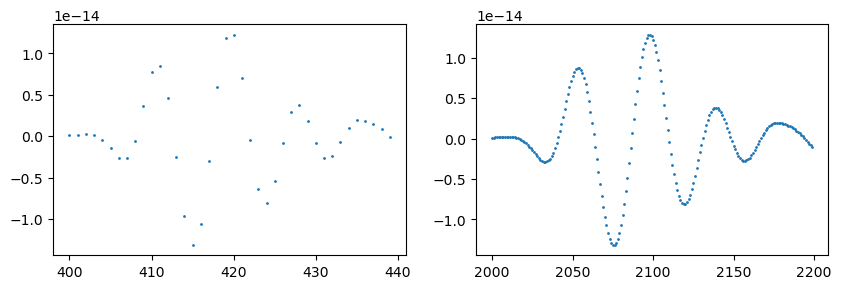

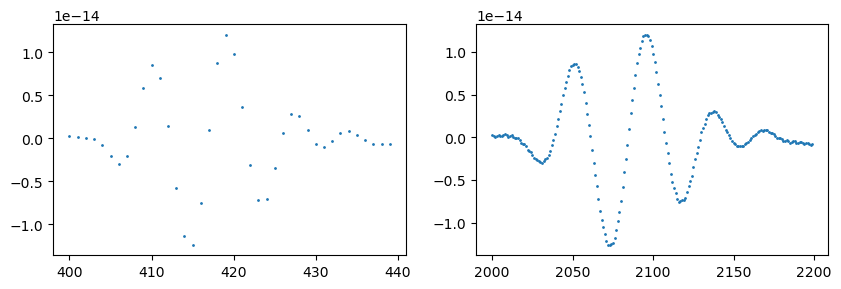

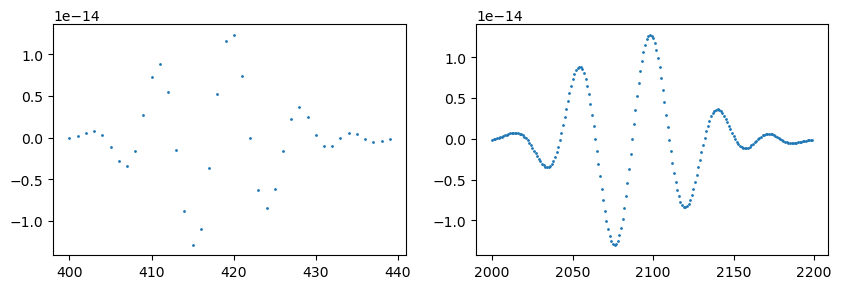

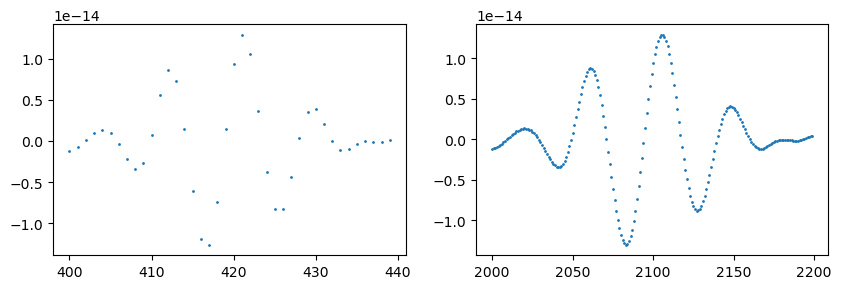

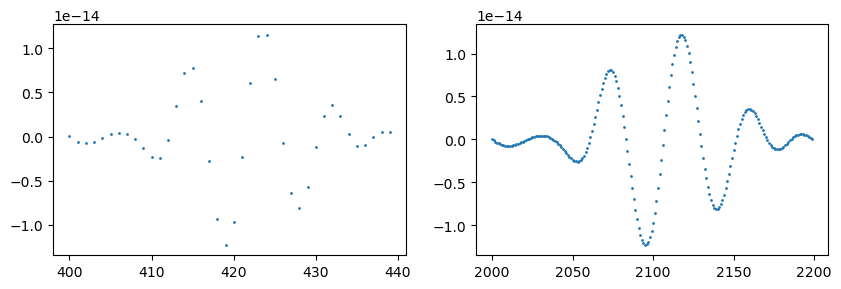

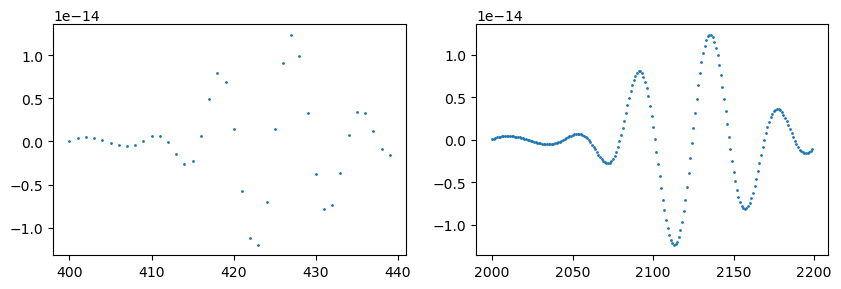

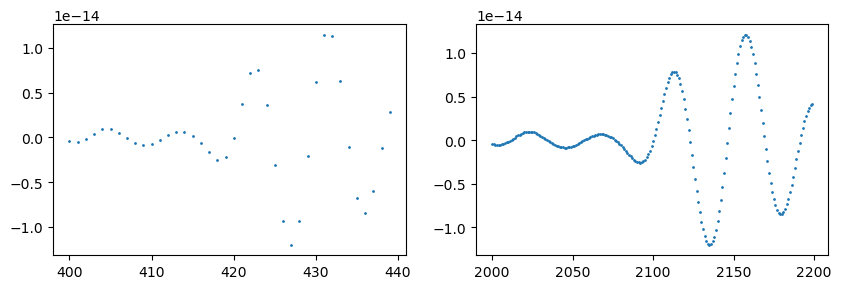

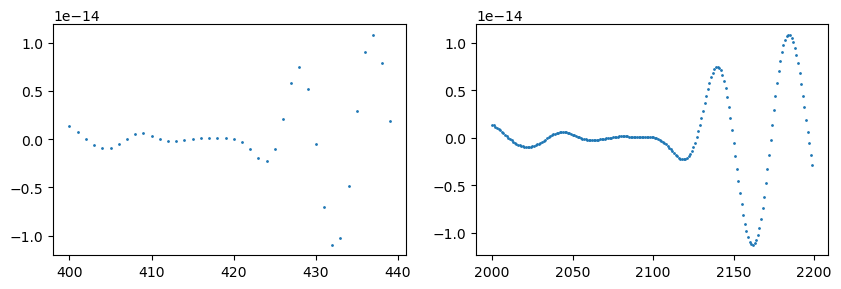

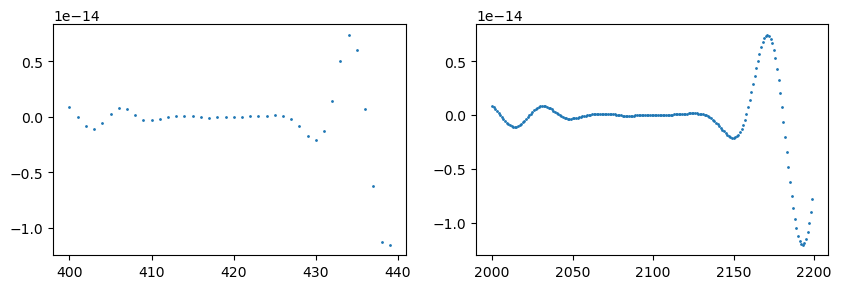

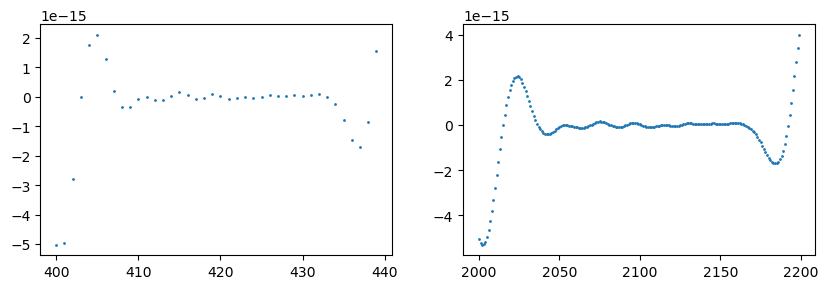

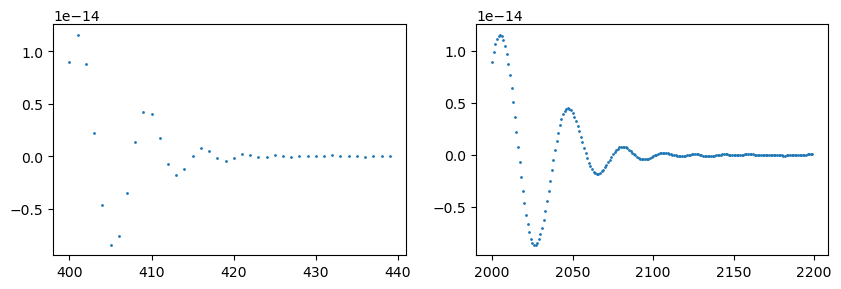

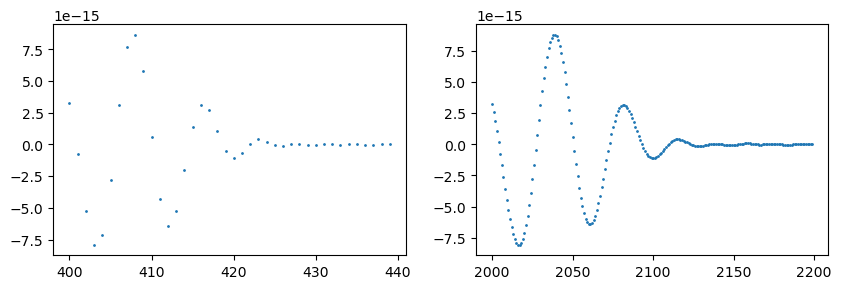

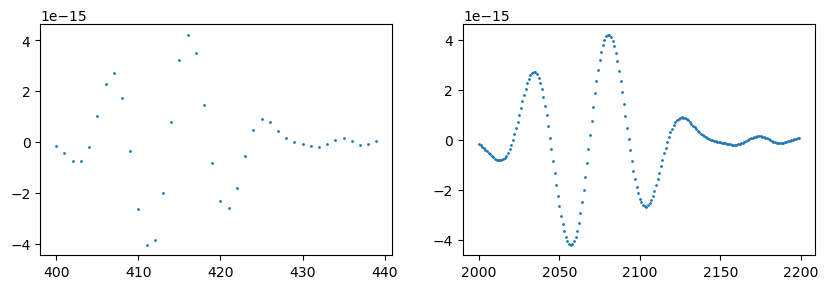

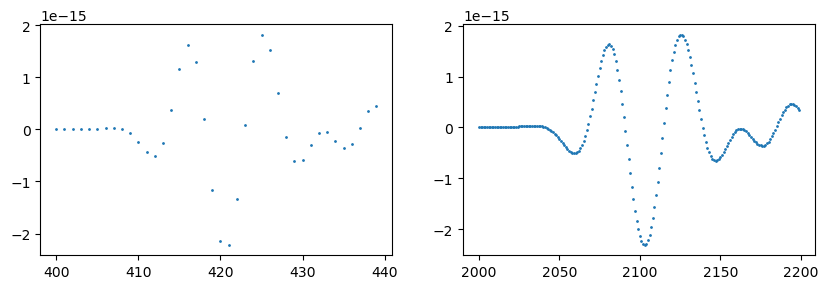

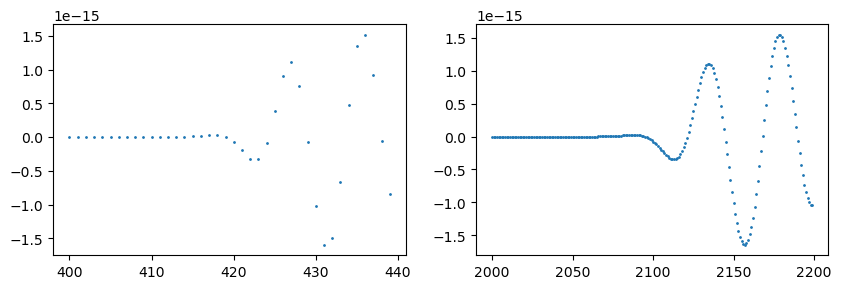

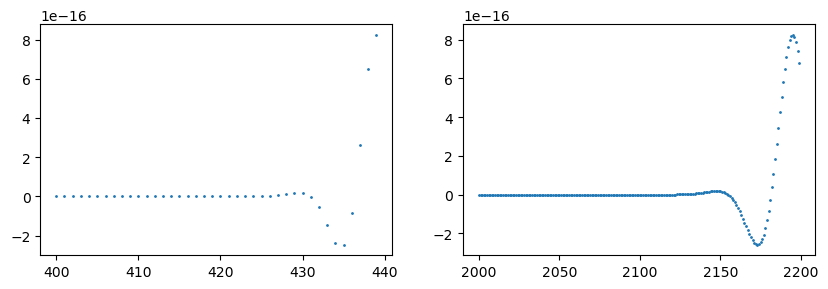

In [5]:
for i in range(0,16):    
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    
    index1, index2 = 400, 440
    x1 = np.arange(index1, index2, 1)
    x2 = np.arange(index1*5, index2*5, 1)
    
    ax.scatter(x1, fmc_sample[:,1,i][index1:index2], s = 1)
    ax2.scatter(x2, fmc[:,1,i][index1*5:index2*5], s = 1)
#     ax.plot(x1, fmc_sample[:,1,i][index1:index2])
#     ax2.plot(x2, fmc[:,1,i][index1*5:index2*5])
    plt.show()

# Scaling Investigation

In [6]:
pickle_in = open("training_data_subsampled.pickle","rb")
train_data = np.array(pickle.load(pickle_in), dtype=object)
print(f'The shape of entire training dataset: {train_data.shape}')
print(f'The shape of a dataset: {train_data[1].shape}')
print(f'The shape of a matrix: {train_data[1][0].shape}')
print(f'The shape of an image: {train_data[1][1].shape}')
print(f'The type of an index: {type(train_data[1][2])}')

The shape of entire training dataset: (2000, 3)
The shape of a dataset: (3,)
The shape of a matrix: (895, 16, 16)
The shape of an image: (180, 240)
The type of an index: <class 'int'>


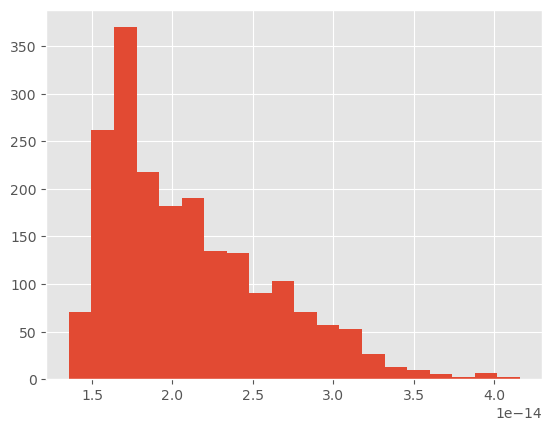

4.158935709060075e-14


In [30]:
fmc = train_data[:,0]

max_num = []
for i in range(len(fmc)):
    max_num.append(np.max(fmc[i]))

# plt.style.use('ggplot')
plt.hist(max_num, bins=20)
plt.show()
print(np.max(max_num))

In [19]:
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12]).reshape(3,2,2)
np.max(a)

12

# Other

(895, 16, 16)
Difference between pair -0.0


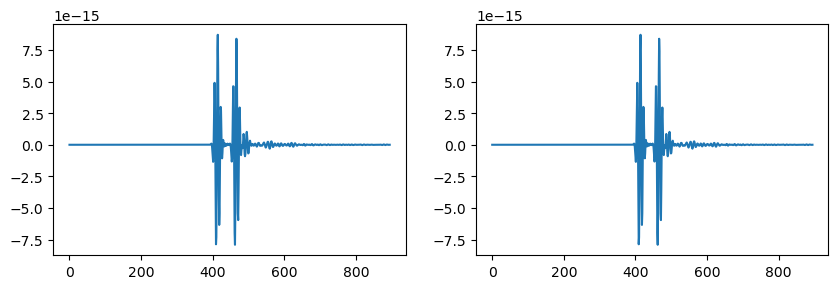

Difference between pair -0.0


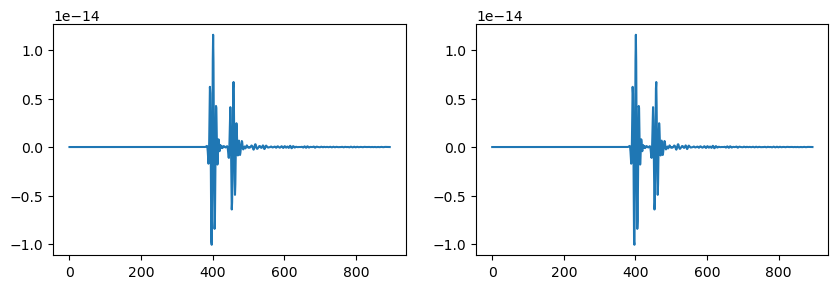

Difference between pair 0.0


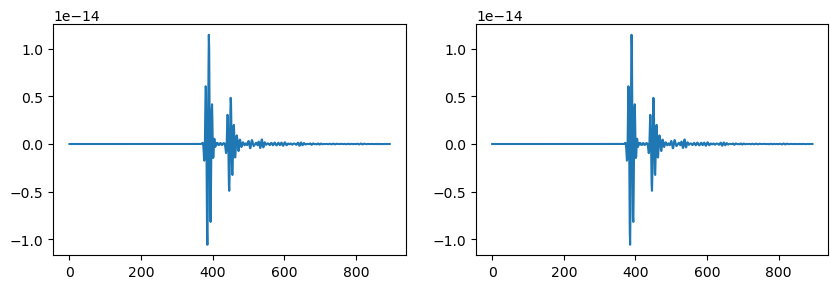

Difference between pair 0.0


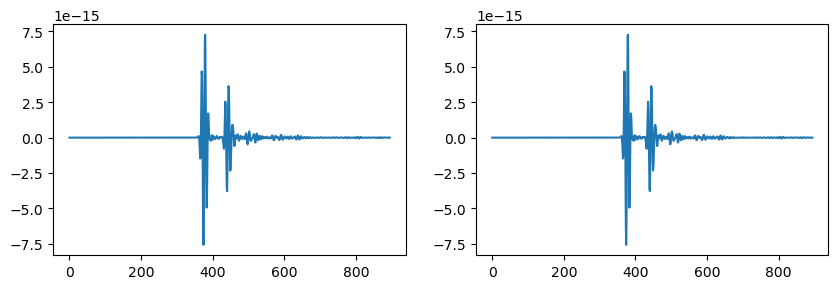

Difference between pair -0.0


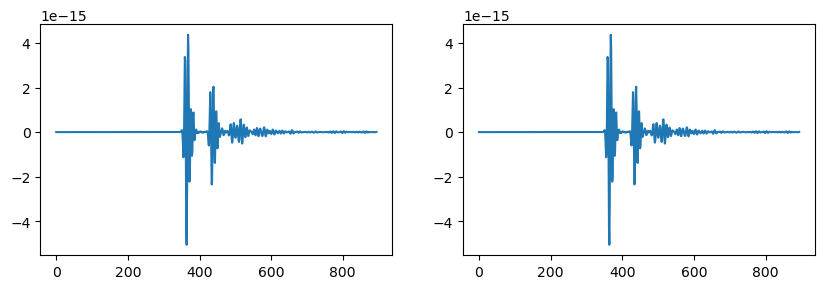

Difference between pair -0.0


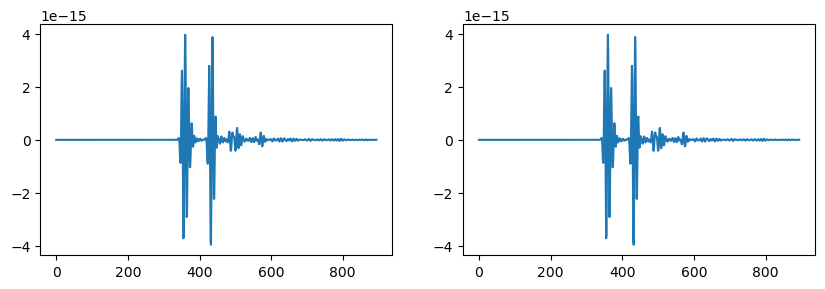

Difference between pair -0.0


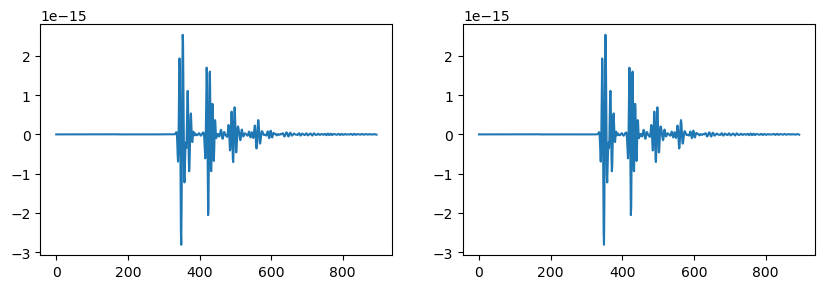

Difference between pair 0.0


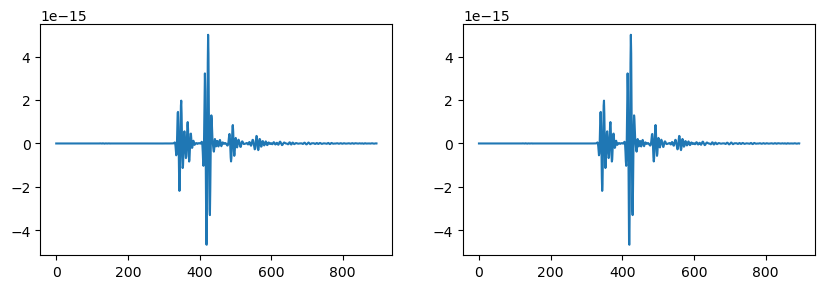

Difference between pair -0.0


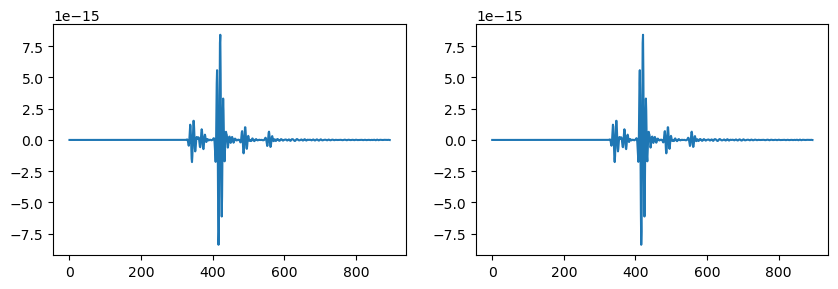

Difference between pair 0.0


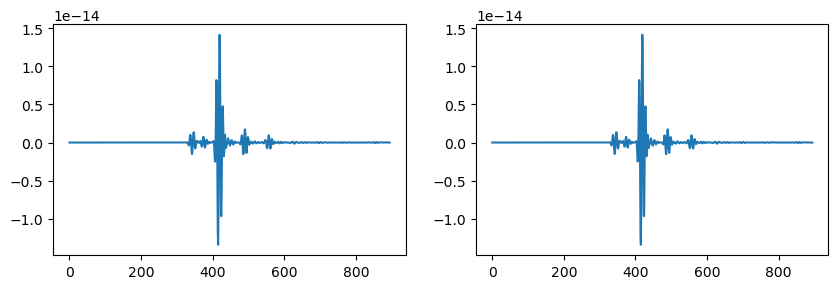

Difference between pair 0.0


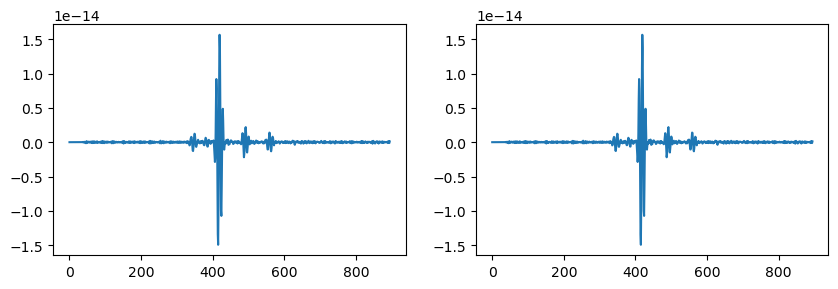

Difference between pair -0.0


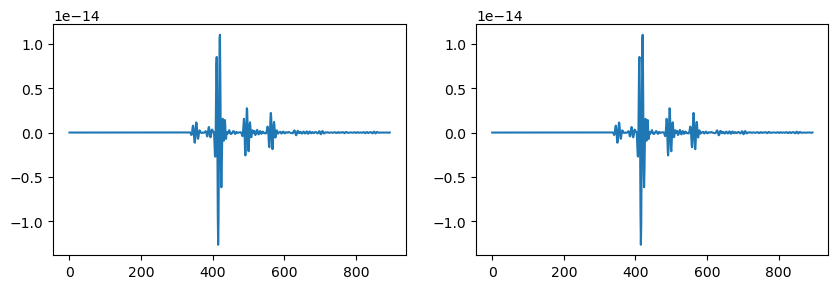

Difference between pair -0.0


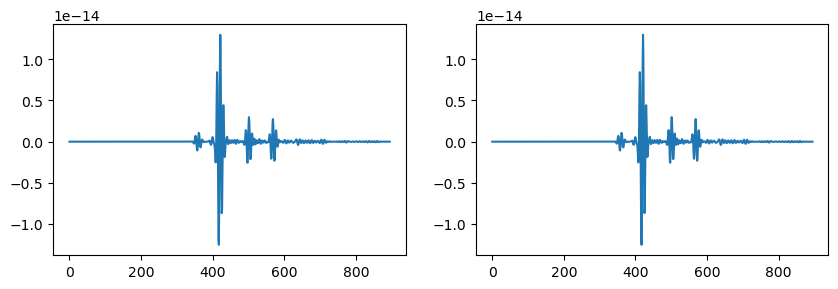

Difference between pair -0.0


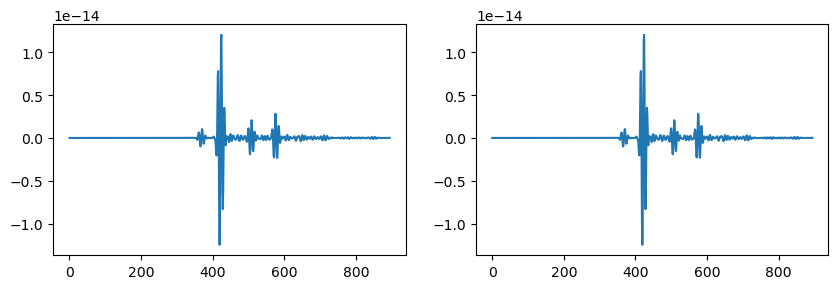

Difference between pair 0.0


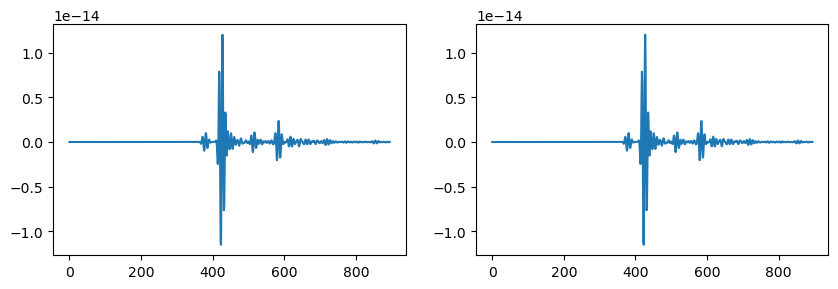

Difference between pair -0.0


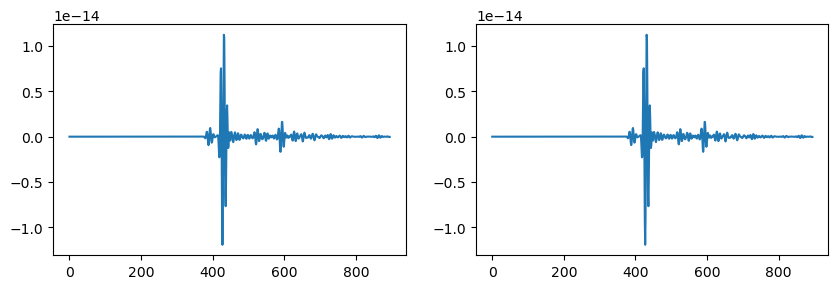

In [17]:
randnum = 10
fmc_sample = fmc[0::5]
print(fmc_sample.shape)

for i in range(0,16): 
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.plot(fmc_sample[:,i,randnum])
    ax2.plot(fmc_sample[:,randnum,i])
    diff = np.sum(fmc_sample[:,i,randnum]-fmc_sample[:,randnum,i])
    print(f'Difference between pair {round(diff, 5)}')
    plt.show()

## Image processing using opencv
https://github.com/MC-Kangan/opencv-course

In [14]:
import cv2 as cv
def rescaleFrame(frame, scale=0.75):
    # Images, Videos and Live Video
    width = int(frame.shape[1] * scale)
    height = int(frame.shape[0] * scale)

    dimensions = (width,height)

    return cv.resize(frame, dimensions, interpolation=cv.INTER_AREA)

In [19]:
a = '1/2/3'
a.split('/')[-1]

'3'

## Max

In [10]:
import numpy as np
fmc_csv = np.loadtxt('FMC.csv', delimiter=',')

In [59]:
mat = scipy.io.loadmat('timeTraces.mat')
fmc = mat['timeTraces'].reshape(-1, 256)
(npxf, npyf) = fmc.shape


FMCs = np.zeros((npxf, npyf))
FMCs[:, :] = fmc

print(FMCs.shape)
a = np.expand_dims(FMCs, axis = 2)

(4472, 256)


In [60]:
mat = scipy.io.loadmat('timeTraces.mat')
fmc = mat['timeTraces']
fmc = fmc[0::5] / 1.75e-14
fmc.shape

(895, 16, 16)

## Find the first non-zero element

In [2]:
pickle_in = open("training_data_subsampled_X.pickle","rb")
X = np.array(pickle.load(pickle_in), dtype=object)
print(f'The shape of entire training dataset: {X.shape}')
print(f'The shape of a dataset: {X[1].shape}')

The shape of entire training dataset: (2000, 895, 16, 16, 1)
The shape of a dataset: (895, 16, 16, 1)


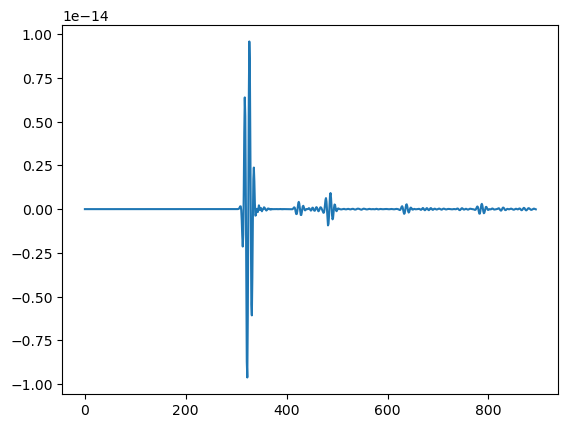

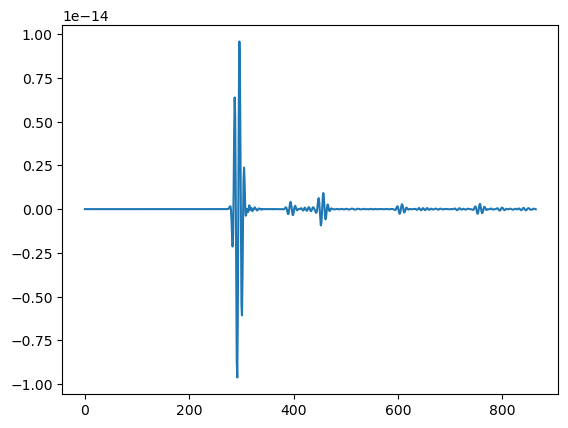

(2000, 895, 16, 16, 1)
(2000, 865, 16, 16, 1)


In [7]:
shrinkX = X[:,30:]
plt.plot(X[30][:,10,1])
plt.show()
plt.plot(shrinkX[30][:,10,1])
plt.show()
print(X.shape)
print(shrinkX.shape)

In [7]:
def find_nonzero(lst):
    front_index = 0
    back_index = 0
    
    for i in range(len(lst)):
        if lst[i] != 0:
            front_index = i
            break
            
    for j in range(0, -len(lst), -1):
        if lst[j] != 0:
            back_index = len(lst)+j
            break
    return front_index, back_index


In [8]:
front_index_list = []
back_index_list = []

X = np.squeeze(X)
for i in range(2000):
    for layer in range(0,16):
        for col in range(0,16):
            front_index, back_index = find_nonzero(X[i][:,col,layer])
            front_index_list.append(front_index)
            back_index_list.append(back_index)


In [13]:
savetxt('front_index_list.csv', front_index_list, delimiter=',')
savetxt('back_index_list.csv', back_index_list, delimiter=',')

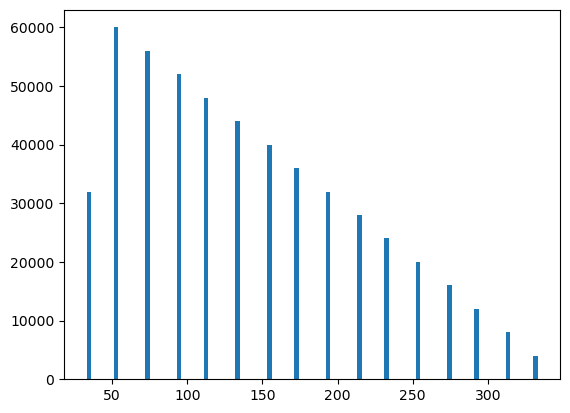

In [86]:
hist = plt.hist(front_index_list, bins = 100)

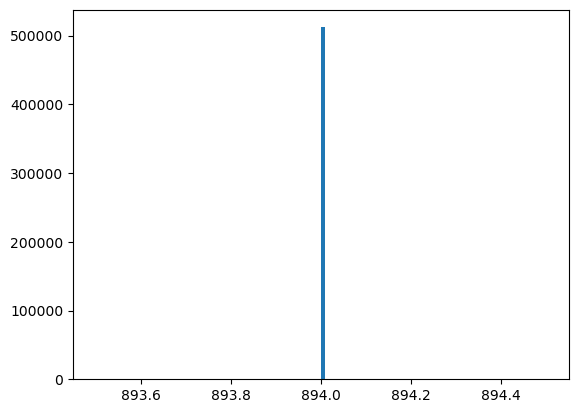

In [87]:
hist = plt.hist(back_index_list, bins = 100)

In [ ]:
pickle_in = open("data_subsampled_no_backwall_crop_y.pickle","rb")
y = np.array(pickle.load(pickle_in), dtype=object)
print(f'The shape of entire training dataset: {y.shape}')
print(f'The shape of a dataset: {y[1].shape}')

In [ ]:
y = y.reshape(-1, 120*240)
y[y==0] = -1
y[y==255] = 1

set(y[0].tolist())